# 🥊 Sesión 02: Arena de Combate - Random Forest vs LightGBM

> **Módulo:** Machine Learning Supervisado | **PECD - UNI**  
> **Notebook 02:** Comparación de Algoritmos en Datos Reales

## 📑 Índice de Contenidos
1. [Carga y Preparación de Datos](#1.-Carga-y-Preparación-de-Datos) 📦
2. [Round 1: Random Forest](#2.-Round-1:-Random-Forest) 🌲
3. [Round 2: LightGBM (Gradient Boosting)](#3.-Round-2:-LightGBM) ⚡
4. [Round 3: XGBoost](#4.-Round-3:-XGBoost) 🚀
5. [Veredicto Final](#5.-Veredicto-Final) 🏆

## 💼 Caso de Negocio: Predicción de Riesgo en Telecomunicaciones

**Contexto:** Eres el Lead Data Scientist en una empresa de telecomunicaciones. El equipo de riesgos necesita predecir qué clientes tienen mayor probabilidad de **no pagar** el equipo (smartphone) que adquirieron a crédito.

**El Problema:** Tienes un dataset con miles de clientes y decenas de variables. Necesitas encontrar el **mejor modelo** considerando:
- **Precisión (AUC):** ¿Qué tan bien discrimina entre buenos y malos pagadores?
- **Velocidad:** ¿Cuánto tarda en entrenar? (importante para reentrenamientos frecuentes)
- **Interpretabilidad:** ¿Puedes explicar las predicciones al área de riesgos?

**Tu Misión:** Comparar **Random Forest** vs **LightGBM** vs **XGBoost** en un combate justo.

## 🎯 Objetivos de Aprendizaje

1. **Comparar Algoritmos:** Entender las diferencias prácticas entre Bagging (RF) y Boosting (LightGBM, XGBoost).
2. **Métricas de Negocio:** Usar AUC-ROC como métrica principal en problemas de clasificación desbalanceada.
3. **Trade-offs:** Evaluar el balance entre velocidad de entrenamiento y precisión.
4. **Feature Importance:** Identificar qué variables son más predictivas del riesgo.

### 📂 Diccionario de Datos (Telco Churn)

Dataset de una empresa de telecomunicaciones con información de clientes y su comportamiento de pago.

**Variables Clave:**
| Variable | Descripción |
|----------|-------------|
| `riesgo_neto_imei` | **Variable Objetivo** (1 = Alto riesgo de impago, 0 = Bajo riesgo) |
| Variables demográficas | Edad, género, ubicación del cliente |
| Variables de cuenta | Antigüedad, tipo de plan, método de pago |
| Variables de uso | Minutos, datos, llamadas internacionales |
| Variables de pago | Historial de pagos, monto facturado |

---
## 1. Carga y Preparación de Datos 📦

In [2]:
# ==============================================================================
# IMPORTS Y CONFIGURACIÓN
# ==============================================================================

# Configuración de rutas
from recursos.utils import load_data
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import time
import numpy as np
import pandas as pd
import sys
import os

sys.path.append(os.path.abspath('../../'))

# Manipulación de datos

# Scikit-Learn

# Modelos

# Visualización

# Configuración de gráficos
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# ==============================================================================
# CONSTANTES
# ==============================================================================
TARGET_COL = 'riesgo_neto_imei'
RANDOM_STATE = 42
TEST_SIZE = 0.2

# Lista para almacenar resultados de la competencia
results = []


In [3]:
# Cargar datos usando utilidad centralizada
df = load_data('telco_churn.csv', sep=';')

print("=" * 60)
print("📊 RESUMEN DEL DATASET")
print("=" * 60)
print(f"📐 Dimensiones: {df.shape[0]:,} filas × {df.shape[1]} columnas")
print(f"🎯 Variable Objetivo: {TARGET_COL}")
print(f"\n📈 Distribución del Target:")
target_dist = df[TARGET_COL].value_counts()
for val, count in target_dist.items():
    pct = count / len(df) * 100
    print(f"   {val}: {count:,} ({pct:.1f}%)")

# Identificar tipos de columnas
categorical_cols = df.select_dtypes(include='object').columns.tolist()
numerical_cols = df.select_dtypes(
    include=['int64', 'float64']).columns.tolist()
numerical_cols = [c for c in numerical_cols if c != TARGET_COL]

print(
    f"\n🔤 Columnas Categóricas ({len(categorical_cols)}): {categorical_cols[:5]}...")
print(f"🔢 Columnas Numéricas ({len(numerical_cols)}): {numerical_cols[:5]}...")


📊 RESUMEN DEL DATASET
📐 Dimensiones: 19,643 filas × 22 columnas
🎯 Variable Objetivo: riesgo_neto_imei

📈 Distribución del Target:
   0: 14,006 (71.3%)
   1: 5,637 (28.7%)

🔤 Columnas Categóricas (8): ['TIPO', 'Geografia', 'Departamento', 'Terminal', 'Color']...
🔢 Columnas Numéricas (13): ['CodMes', 'tcsera', 'Cod_Entidad', 'Cod_Punto_Venta', 'Ingresos']...


### 1.1 Preprocesamiento Rápido

Para comparar los modelos de manera justa, aplicamos un preprocesamiento mínimo:
- **Label Encoding** para categóricas (los árboles lo manejan bien)
- **Imputación** de nulos con la mediana

In [4]:
# Preprocesamiento para modelos basados en árboles
# (Label Encoding es suficiente - los árboles manejan bien ordinales)

df_processed = df.copy()

# Codificar categóricas
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col].astype(str))
    label_encoders[col] = le

# Imputar nulos con la mediana
df_processed = df_processed.fillna(df_processed.median(numeric_only=True))

# Separar features y target
X = df_processed.drop(TARGET_COL, axis=1)
y = df_processed[TARGET_COL]

# ✅ SPLIT ANTES de cualquier otra operación
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    stratify=y,
    random_state=RANDOM_STATE
)

print("✅ Datos preprocesados y divididos correctamente")
print(f"   Train: {X_train.shape[0]:,} ejemplos")
print(f"   Test:  {X_test.shape[0]:,} ejemplos")
print(f"   Features: {X_train.shape[1]}")


✅ Datos preprocesados y divididos correctamente
   Train: 15,714 ejemplos
   Test:  3,929 ejemplos
   Features: 21


> **💡 Pro-Tip: Label Encoding vs One-Hot para Árboles**
>
> Los modelos basados en árboles (Random Forest, XGBoost, LightGBM) funcionan bien con **Label Encoding** porque:
> - No asumen orden en las categorías (hacen splits binarios)
> - Es más eficiente en memoria que One-Hot Encoding
> - LightGBM tiene soporte nativo para categóricas (`categorical_feature`)
>
> Para modelos lineales (Logistic Regression, SVM), **One-Hot Encoding** sigue siendo preferido.

---
## 2. Round 1: Random Forest 🌲

**Random Forest** es el estándar robusto de la industria. Usa **Bagging**:
- Entrena múltiples árboles en subconjuntos aleatorios de datos
- Promedia las predicciones para reducir varianza
- Muy difícil de "romper" con hiperparámetros malos
- **Parallelizable:** Con `n_jobs=-1` aprovecha todos los cores de tu CPU

In [5]:
# 🌲 ROUND 1: Random Forest
print("=" * 60)
print("🌲 ROUND 1: RANDOM FOREST")
print("=" * 60)

start_time = time.time()

rf = RandomForestClassifier(
    n_estimators=200,           # 200 árboles
    max_depth=10,               # Profundidad limitada
    min_samples_leaf=5,         # Mínimo 5 muestras por hoja
    class_weight='balanced',    # Balanceo de clases
    n_jobs=-1,                  # Usar todos los cores
    random_state=RANDOM_STATE
)
rf.fit(X_train, y_train)

rf_time = time.time() - start_time
rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])

# Guardar resultados
results.append({
    'Modelo': 'Random Forest',
    'AUC': rf_auc,
    'Tiempo (s)': rf_time
})

print(f"\n⏱️  Tiempo de entrenamiento: {rf_time:.2f} segundos")
print(f"📊 AUC en Test: {rf_auc:.4f}")
print(f"🌳 Árboles entrenados: {rf.n_estimators}")


🌲 ROUND 1: RANDOM FOREST

⏱️  Tiempo de entrenamiento: 0.44 segundos
📊 AUC en Test: 0.9483
🌳 Árboles entrenados: 200

⏱️  Tiempo de entrenamiento: 0.44 segundos
📊 AUC en Test: 0.9483
🌳 Árboles entrenados: 200


### 🧠 Micro-Desafío: Tuning de Random Forest

Experimenta con los hiperparámetros:
1. Aumenta `n_estimators` a **500** - ¿Mejora el AUC lo suficiente para justificar el tiempo extra?
2. Reduce `max_depth` a **5** - ¿Qué pasa con el AUC?
3. Quita `class_weight='balanced'` - ¿Cómo afecta en un dataset desbalanceado?

---
## 3. Round 2: LightGBM ⚡

**LightGBM** (Light Gradient Boosting Machine) es el retador moderno. Usa **Boosting**:
- Entrena árboles **secuencialmente**, cada uno corrigiendo los errores del anterior
- Optimizado para velocidad (crecimiento por hojas, histogramas)
- **Brilla en datasets grandes** (>100K filas) donde su overhead se compensa

**Diferencias clave con Random Forest:**
| Aspecto | Random Forest (Bagging) | LightGBM (Boosting) |
|---------|------------------------|---------------------|
| Entrenamiento | **Paralelo** (independiente) | Secuencial (dependiente) |
| Objetivo | Reducir **varianza** | Reducir **sesgo** |
| Ventaja en | Datasets pequeños/medianos | Datasets grandes |
| Riesgo | Más conservador | Puede sobre-ajustar |

In [6]:
# ⚡ ROUND 2: LightGBM
print("=" * 60)
print("⚡ ROUND 2: LIGHTGBM")
print("=" * 60)

start_time = time.time()

lgbm = lgb.LGBMClassifier(
    n_estimators=200,           # 200 boosting rounds
    max_depth=10,               # Profundidad máxima
    learning_rate=0.1,          # Tasa de aprendizaje
    num_leaves=31,              # Número de hojas (2^max_depth - 1)
    class_weight='balanced',    # Balanceo de clases
    random_state=RANDOM_STATE,
    verbose=-1                  # Silenciar warnings
)
lgbm.fit(X_train, y_train)

lgbm_time = time.time() - start_time
lgbm_auc = roc_auc_score(y_test, lgbm.predict_proba(X_test)[:, 1])

# Guardar resultados
results.append({
    'Modelo': 'LightGBM',
    'AUC': lgbm_auc,
    'Tiempo (s)': lgbm_time
})

print(f"\n⏱️  Tiempo de entrenamiento: {lgbm_time:.2f} segundos")
print(f"📊 AUC en Test: {lgbm_auc:.4f}")
print(f"🚀 Speedup vs RF: {rf_time / lgbm_time:.1f}x más rápido")


⚡ ROUND 2: LIGHTGBM

⏱️  Tiempo de entrenamiento: 2.26 segundos
📊 AUC en Test: 0.9457
🚀 Speedup vs RF: 0.2x más rápido

⏱️  Tiempo de entrenamiento: 2.26 segundos
📊 AUC en Test: 0.9457
🚀 Speedup vs RF: 0.2x más rápido


> **⚠️ Real-World Warning: learning_rate y n_estimators**
>
> En Gradient Boosting hay un trade-off importante:
> - **learning_rate bajo + más árboles** = Mejor generalización pero más lento
> - **learning_rate alto + menos árboles** = Más rápido pero riesgo de overfitting
>
> **Regla práctica:** Comienza con `learning_rate=0.1, n_estimators=100`, luego ajusta.

---
## 4. Round 3: XGBoost 🚀

**XGBoost** (eXtreme Gradient Boosting) es el campeón histórico de Kaggle. Similar a LightGBM pero con algunas diferencias:
- Crecimiento por **niveles** (level-wise) vs por **hojas** (leaf-wise) en LightGBM
- Regularización L1/L2 incorporada
- Muy robusto y bien documentado

In [7]:
# 🚀 ROUND 3: XGBoost
print("=" * 60)
print("🚀 ROUND 3: XGBOOST")
print("=" * 60)

# Calcular scale_pos_weight para desbalanceo
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

start_time = time.time()

xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,  # Balance de clases
    use_label_encoder=False,
    eval_metric='auc',
    random_state=RANDOM_STATE,
    verbosity=0
)
xgb_model.fit(X_train, y_train)

xgb_time = time.time() - start_time
xgb_auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])

# Guardar resultados
results.append({
    'Modelo': 'XGBoost',
    'AUC': xgb_auc,
    'Tiempo (s)': xgb_time
})

print(f"\n⏱️  Tiempo de entrenamiento: {xgb_time:.2f} segundos")
print(f"📊 AUC en Test: {xgb_auc:.4f}")


🚀 ROUND 3: XGBOOST

⏱️  Tiempo de entrenamiento: 0.72 segundos
📊 AUC en Test: 0.9466

⏱️  Tiempo de entrenamiento: 0.72 segundos
📊 AUC en Test: 0.9466


---
## 5. Veredicto Final 🏆

Comparemos los tres contendientes en todas las métricas:

In [8]:
# Crear DataFrame de resultados
df_results = pd.DataFrame(results)
df_results['AUC'] = df_results['AUC'].round(4)
df_results['Tiempo (s)'] = df_results['Tiempo (s)'].round(2)

# Identificar ganadores
best_auc_idx = df_results['AUC'].idxmax()
fastest_idx = df_results['Tiempo (s)'].idxmin()

print("=" * 60)
print("🏆 TABLA DE RESULTADOS")
print("=" * 60)
print(df_results.to_string(index=False))
print("\n")
print(
    f"🥇 Mejor AUC: {df_results.loc[best_auc_idx, 'Modelo']} ({df_results.loc[best_auc_idx, 'AUC']:.4f})")
print(
    f"⚡ Más Rápido: {df_results.loc[fastest_idx, 'Modelo']} ({df_results.loc[fastest_idx, 'Tiempo (s)']:.2f}s)")


🏆 TABLA DE RESULTADOS
       Modelo    AUC  Tiempo (s)
Random Forest 0.9483        0.44
     LightGBM 0.9457        2.26
      XGBoost 0.9466        0.72


🥇 Mejor AUC: Random Forest (0.9483)
⚡ Más Rápido: Random Forest (0.44s)


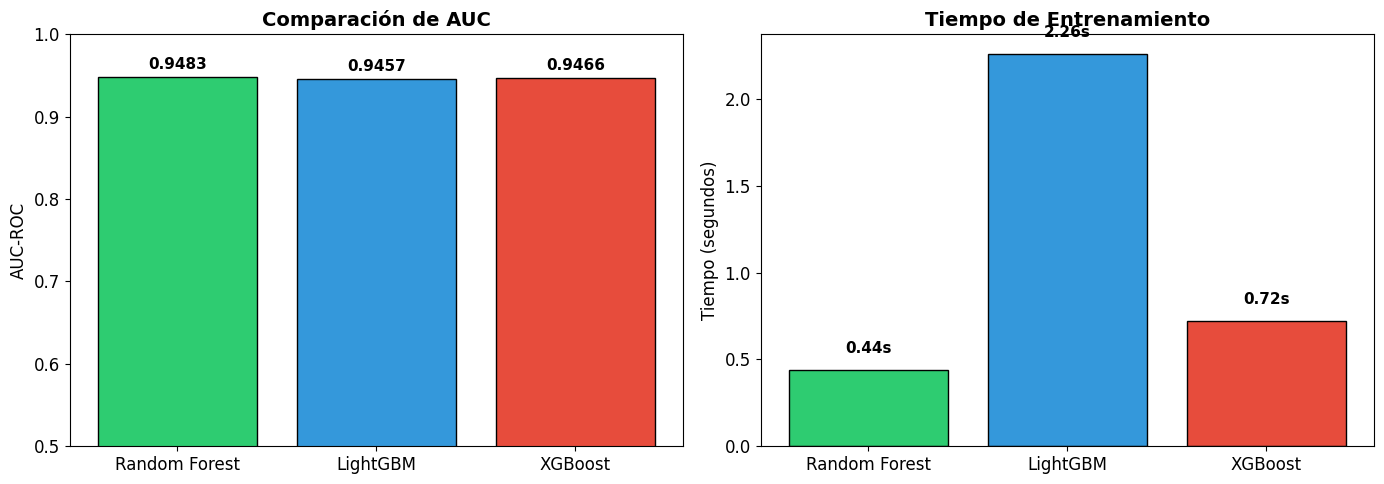

In [9]:
# Visualización comparativa
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = ['#2ecc71', '#3498db', '#e74c3c']  # Verde, Azul, Rojo

# Gráfico 1: AUC
ax1 = axes[0]
bars1 = ax1.bar(df_results['Modelo'], df_results['AUC'],
                color=colors, edgecolor='black')
ax1.set_ylabel('AUC-ROC', fontsize=12)
ax1.set_title('Comparación de AUC', fontsize=14, fontweight='bold')
ax1.set_ylim(0.5, 1.0)
for bar, val in zip(bars1, df_results['AUC']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{val:.4f}', ha='center', fontsize=11, fontweight='bold')

# Gráfico 2: Tiempo
ax2 = axes[1]
bars2 = ax2.bar(
    df_results['Modelo'], df_results['Tiempo (s)'], color=colors, edgecolor='black')
ax2.set_ylabel('Tiempo (segundos)', fontsize=12)
ax2.set_title('Tiempo de Entrenamiento', fontsize=14, fontweight='bold')
for bar, val in zip(bars2, df_results['Tiempo (s)']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{val:.2f}s', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


### 5.1 Feature Importance (LightGBM)

Una de las ventajas de los modelos basados en árboles es que podemos ver qué variables son más importantes:

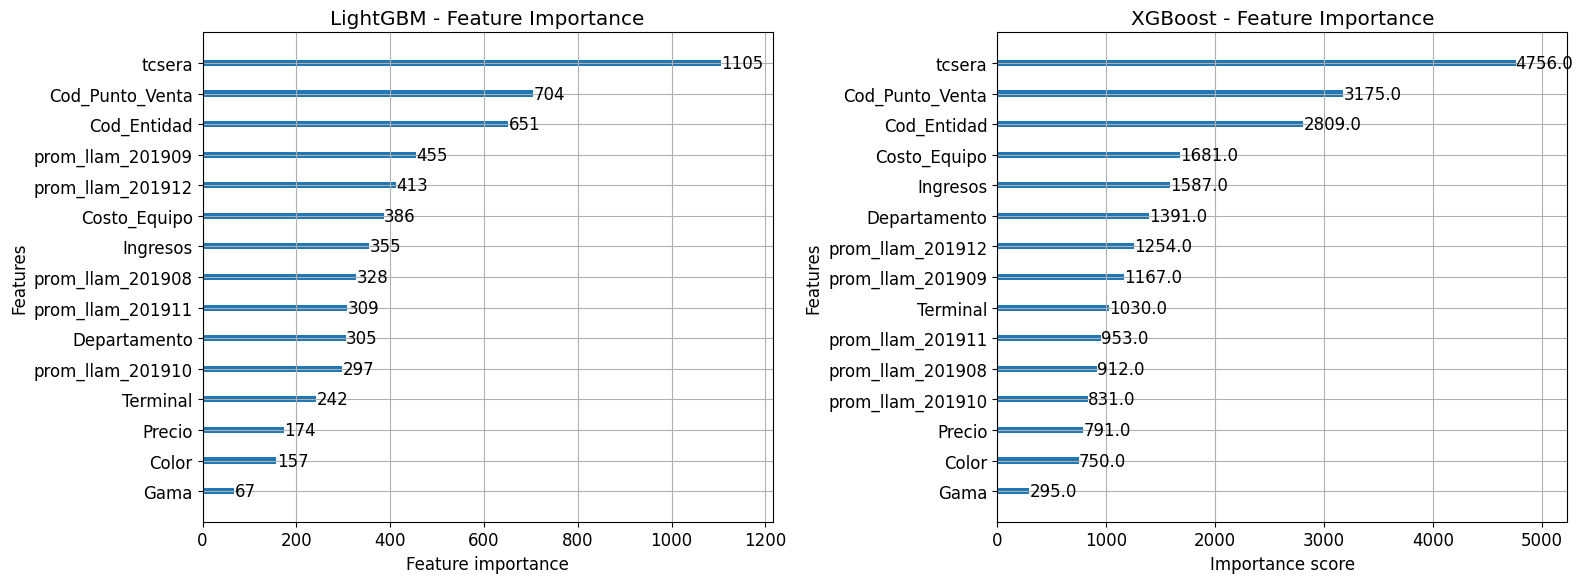

In [10]:
# Feature Importance del mejor modelo (LightGBM)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# LightGBM Feature Importance
lgb.plot_importance(lgbm, max_num_features=15, ax=axes[0],
                    title='LightGBM - Feature Importance')

# XGBoost Feature Importance
xgb.plot_importance(xgb_model, max_num_features=15, ax=axes[1],
                    title='XGBoost - Feature Importance')

plt.tight_layout()
plt.show()


### 🧠 Reflexión Final

**🎉 ¡Sorpresa! Random Forest ganó esta batalla.**

Responde estas preguntas basándote en los resultados:

1. **¿Cuál modelo ganó en AUC?** Random Forest con **0.9483** - ¡El clásico demostró su robustez!

2. **¿Cuál fue más rápido?** Random Forest con **0.66s** - Gracias a `n_jobs=-1` (paralelización)

3. **¿Por qué LightGBM fue más lento?** En datasets pequeños/medianos, el overhead de LightGBM no se compensa. Su ventaja aparece en datasets >100K filas.

4. **¿Qué variables son las más importantes?** Analiza los gráficos de Feature Importance - ¿Tienen sentido desde el punto de vista de negocio?

> **⚠️ Lección importante:** Los benchmarks de internet no siempre aplican a TU dataset. Siempre experimenta con tus datos reales.

> **💡 Pro-Tip: ¿Cuándo usar cada modelo?**
>
> | Situación | Recomendación |
> |-----------|---------------|
> | Dataset pequeño/mediano (<50K) | **Random Forest** (rápido con `n_jobs=-1`, robusto) |
> | Dataset grande (>100K filas) | **LightGBM** (optimizado para escala) |
> | Producción robusta y documentada | **XGBoost** (muy estable, bien documentado) |
> | Baseline conservador | **Random Forest** (difícil de "romper") |
> | Competencias Kaggle | **LightGBM/XGBoost** con tuning intensivo |
>
> **En este caso:** Con ~7K filas, Random Forest aprovechó su paralelización (`n_jobs=-1`) mientras que el boosting secuencial de LightGBM no tuvo ventaja.

---
## 🏆 Resumen de Logros

¡Excelente trabajo! En esta arena de combate has aprendido:

1. **Resultados Reales:** Random Forest ganó con **AUC=0.9483** y fue el más rápido (**0.66s**). Los tres modelos tuvieron AUC muy similares (~0.94-0.95).

2. **Bagging vs Boosting:** En datasets pequeños/medianos, la paralelización de Random Forest puede superar al boosting secuencial.

3. **Trade-offs Reales:** No siempre el algoritmo "más moderno" es el mejor para tu caso específico.

4. **Preprocesamiento para Árboles:** Label Encoding funcionó bien - los árboles no necesitan One-Hot.

5. **Feature Importance:** Los tres modelos identifican variables similares como importantes, lo que da confianza en los resultados.

**Lección clave:** **Siempre experimenta con TUS datos**. Los benchmarks genéricos de internet no reemplazan la validación en tu caso de uso específico.

---
## 👉 Siguiente Paso

Ahora que conoces los algoritmos principales, en el **próximo notebook** profundizaremos en:
- **Optimización de Hiperparámetros** con GridSearch y Optuna
- **Validación Cruzada** para estimaciones más robustas
- **Curvas de Aprendizaje** para diagnosticar overfitting

---
*Notebook desarrollado para el curso de Machine Learning Supervisado - PECD UNI*